In [14]:
import matplotlib.pyplot as plt
import matplotlib as mpl
mpl.rcParams['hatch.linewidth'] = 0.2
import numpy as np
import pandas as pd
import pickle
from tqdm.notebook import tqdm
import polars as pl
import xgboost as xgb
print("xgboost version:", xgb.__version__)

import sys
import os
sys.path.append(os.path.abspath(os.path.join(os.getcwd(), '..')))

from src.signal_categories import topological_category_labels, topological_category_colors, topological_category_labels_latex, topological_category_hatches, topological_categories_dic
from src.signal_categories import filetype_category_labels, filetype_category_colors, filetype_category_hatches
from src.signal_categories import del1g_detailed_category_labels, del1g_detailed_category_colors, del1g_detailed_category_labels_latex, del1g_detailed_category_hatches, del1g_detailed_categories_dic
from src.signal_categories import del1g_simple_category_labels, del1g_simple_category_colors, del1g_simple_category_labels_latex, del1g_simple_category_hatches, del1g_simple_categories_dic
from src.signal_categories import train_category_labels, train_category_labels_latex

from src.ntuple_variables.pandora_variables import pandora_scalar_second_half_training_vars

from src.file_locations import intermediate_files_location

from src.plot_helpers import make_histogram_plot

from src.ntuple_variables.variables import combined_training_vars

from src.df_helpers import lazy_height


xgboost version: 2.0.3


# File Loading

In [15]:
training = "all_vars"
training_vars = combined_training_vars

reco_categories = train_category_labels
reco_category_labels_latex = train_category_labels_latex


In [16]:
print("loading all_df.parquet...")
all_df = pl.scan_parquet(f"{intermediate_files_location}/all_df.parquet")
print(f"num events in all_df: {lazy_height(all_df)}")

# this only includes predictions for events passing the preselection used during training
print("loading predictions.parquet...")
pred_df = pl.scan_parquet(f"../training_outputs/{training}/predictions.parquet")
print(f"num events in predictions.parquet: {lazy_height(pred_df)}")

print("merging all_df and predictions.pkl...")
merged_df_no_data_drop = all_df.join(
    pred_df, 
    on=["filetype", "run", "subrun", "event"], 
    how="left"
)
del all_df
del pred_df

# Use polars expressions to set "used_for_training" and "used_for_testing" for wc_kine_reco_Enu < 0
merged_df_no_data_drop = merged_df_no_data_drop.with_columns([
    pl.when(pl.col("wc_kine_reco_Enu") < 0)
      .then(False)
      .otherwise(pl.col("used_for_training"))
      .alias("used_for_training"),
    pl.when(pl.col("wc_kine_reco_Enu") < 0)
      .then(True)
      .otherwise(pl.col("used_for_testing"))
      .alias("used_for_testing")
])



loading all_df.parquet...
num events in all_df: 6770017
loading predictions.parquet...
num events in predictions.parquet: 2431943
merging all_df and predictions.pkl...


In [17]:
full_pred = merged_df_no_data_drop.filter(
    ~pl.col("filetype").is_in(["data", "isotropic_one_gamma_overlay", "delete_one_gamma_overlay"])
)
full_data = merged_df_no_data_drop.filter(pl.col("filetype") == "data")

prob_categories = ["prob_" + cat for cat in reco_categories]
for prob in prob_categories:
    full_pred = full_pred.with_columns(pl.col(prob).fill_null(-1))
    full_data = full_data.with_columns(pl.col(prob).fill_null(-1))

generic_pred_df = full_pred.filter(pl.col("wc_kine_reco_Enu") > 0)
non_generic_pred_df = full_pred.filter(pl.col("wc_kine_reco_Enu") < 0)
del full_pred

num_train_events = lazy_height(generic_pred_df.filter(pl.col("used_for_training") == True))
num_test_events = lazy_height(generic_pred_df.filter(pl.col("used_for_testing") == True))

#num_train_events = generic_pred_df.filter(pl.col("used_for_training") == True).height
#num_test_events = generic_pred_df.filter(pl.col("used_for_testing") == True).height
print(f"num_train_events: {num_train_events}, num_test_events: {num_test_events}")
frac_test = num_test_events / (num_train_events + num_test_events)
print(f"weighting up preselected prediction events by the fraction of test/train events: {frac_test:.3f}")

# Modify weights using polars expressions
generic_pred_df = generic_pred_df.with_columns(
    pl.when(pl.col("used_for_testing"))
    .then(pl.col("wc_net_weight") / frac_test)
    .otherwise(pl.col("wc_net_weight"))
    .alias("wc_net_weight")
)

full_pred = pl.concat([generic_pred_df, non_generic_pred_df])
del generic_pred_df
del non_generic_pred_df

test_pred = full_pred.filter(pl.col("used_for_testing") == True)


num_train_events: 993344, num_test_events: 992842
weighting up preselected prediction events by the fraction of test/train events: 0.500


In [18]:
merged_df = pl.concat([test_pred, full_data])
del test_pred
del full_data
presel_merged_df_allvars = merged_df.filter(pl.col("wc_kine_reco_Enu") > 0)

presel_merged_data_df_allvars = presel_merged_df_allvars.filter(pl.col("filetype") == "data")
presel_merged_pred_df_allvars = presel_merged_df_allvars.filter(pl.col("filetype") != "data")


In [19]:
# Create boolean expressions for each condition
shw_sp_n_20mev_showers_expr = pl.col("wc_shw_sp_n_20mev_showers") > 0
reco_nuvtxX_expr = (pl.col("wc_reco_nuvtxX") > 5.0) & (pl.col("wc_reco_nuvtxX") < 250.0)
single_photon_numu_score_expr = pl.col("wc_single_photon_numu_score") > 0.4
single_photon_other_score_expr = pl.col("wc_single_photon_other_score") > 0.2
single_photon_ncpi0_score_expr = pl.col("wc_single_photon_ncpi0_score") > -0.05
single_photon_nue_score_expr = pl.col("wc_single_photon_nue_score") > -1.0
shw_sp_n_20br1_showers_expr = pl.col("wc_shw_sp_n_20br1_showers") == 1

# Combine all conditions
selection_expr = (
    shw_sp_n_20mev_showers_expr &
    reco_nuvtxX_expr &
    single_photon_numu_score_expr &
    single_photon_other_score_expr &
    single_photon_ncpi0_score_expr &
    single_photon_nue_score_expr &
    shw_sp_n_20br1_showers_expr
)

# Add selection column using when/then/otherwise
presel_merged_df_allvars = presel_merged_df_allvars.with_columns(
    pl.when(selection_expr)
    .then(1)
    .otherwise(0)
    .alias("erin_inclusive_1g_sel")
)


In [20]:
# Get the probabilities and find argmax index for each row
presel_merged_df_allvars = presel_merged_df_allvars.with_columns(
    pl.concat_list(prob_categories).list.arg_max().alias("reco_category_argmax_index")
)

# Build list of query strings
reco_category_argmax_queries = []
for i, signal_category in enumerate(reco_categories):
    reco_category_argmax_queries.append(pl.col("reco_category_argmax_index") == i)


In [21]:
name_expr_priority_vals_w_None = [
    ("1gNp", pl.col("prob_1gNp") > 0.3, 1),
    ("1g0p", pl.col("prob_1g0p") > 0.9, 2),
    ("1gNp1mu", pl.col("prob_1gNp1mu") > 0.5, 3),
    ("1g0p1mu", pl.col("prob_1g0p1mu") > 0.2, 4),
    ("1g_outFV", pl.col("prob_1g_outFV") > 0.5, 5),
    ("NC1pi0_Np", None, 6),
    ("NC1pi0_0p", None, 7),
    ("numuCC1pi0_Np", pl.col("prob_numuCC1pi0_Np") > 0.1, 9),
    ("numuCC1pi0_0p", pl.col("prob_numuCC1pi0_0p") > 0.15, 8), # 0p takes priority over Np in orthogonality
    ("1pi0_outFV", pl.col("prob_1pi0_outFV") > 0.1, 10),
    ("nueCC_Np", pl.col("prob_nueCC_Np") > 0.05, 12),
    ("nueCC_0p", pl.col("prob_nueCC_0p") > 0.05, 11), # 0p takes priority over Np in orthogonality
    ("numuCC_Np", pl.col("prob_numuCC_Np") > 0.5, 13),
    ("numuCC_0p", pl.col("prob_numuCC_0p") > 0.5, 14),
    ("other_outFV_dirt", None, 15),
    ("multi_pi0", pl.col("prob_multi_pi0") > 0.02, 16),
    ("eta_other", pl.col("prob_eta_other") > 0.01, 17),
    ("pi0_dalitz_decay", pl.col("prob_pi0_dalitz_decay") > 0.1, 5.5), # high priority for dalitz, rare topology
    ("NC_no_gamma", None, 19),
    ("ext", None, 20),
]

name_expr_priority_vals_possible_overlap = []
for i, name_expr_priority_val_w_None in enumerate(name_expr_priority_vals_w_None):
    name, expr, priority = name_expr_priority_val_w_None
    if expr is None:
        expr = reco_category_argmax_queries[i]
    name_expr_priority_vals_possible_overlap.append((name, expr, priority))

name_expr_priority_vals_possible_overlap.sort(key=lambda x: x[2])

name_expr_priority_vals = []
for i, name_expr_priority_val_possible_overlap in enumerate(name_expr_priority_vals_possible_overlap):
    name, expr, priority = name_expr_priority_val_possible_overlap
    for j in range(i):
        expr = expr & ~name_expr_priority_vals_possible_overlap[j][1]
    name_expr_priority_vals.append((name, expr, priority))

reco_category_query_dic = {}
for name, expr, priority in name_expr_priority_vals:
    reco_category_query_dic[name] = expr

reco_category_queries = []
for reco_category in reco_categories:
    reco_category_queries.append(reco_category_query_dic[reco_category])

#for query in reco_category_queries:
#    print("\n", query)

# saving this to a file so we can apply the same cuts in the efficiency plots
with open(f"{intermediate_files_location}/reco_category_queries.pkl", "wb") as f:
    pickle.dump(reco_category_queries, f)

In [22]:
# load columns from presel_merged_df
load_vars = list(presel_merged_df_allvars.collect_schema().names())

# remove columns combined_training_vars variables, tons of variables that aren't needed
load_vars = [col for col in load_vars if not (col in combined_training_vars)]

# TEMPORARY, since we didn't exclude all the pandora postprocessing variables
#load_vars = [col for col in load_vars if not (["pandora_max" in col])]

extra_vars = [
    "wc_kine_reco_Enu",
    "wc_reco_num_protons_35_MeV",
    "wc_reco_backwards_projected_dist",
    "wc_reco_distance_to_boundary",
    "wc_reco_shower_theta",
    "wc_reco_shower_phi",
    "wc_kine_pio_mass",
    "lantern_diphoton_mass",
]

# add back in the current variable
for var in extra_vars:
    if var not in load_vars:
        load_vars.append(var)

print(load_vars)

['blip_closest_upstream_angle', 'blip_closest_upstream_distance', 'blip_closest_upstream_dw', 'blip_closest_upstream_dx', 'blip_closest_upstream_energy', 'blip_closest_upstream_impact_parameter', 'detailed_run_period', 'event', 'filename', 'filetype', 'glee_reco_asso_showers', 'glee_reco_slice_num', 'glee_reco_vertex_size', 'glee_reco_vertex_x', 'glee_reco_vertex_y', 'glee_reco_vertex_z', 'lantern_blip_minDist', 'lantern_blip_minDist_energy', 'lantern_blip_nWithin_100cm', 'lantern_blip_nWithin_10cm', 'lantern_blip_nWithin_30cm', 'lantern_blip_nWithin_50cm', 'lantern_blip_nWithin_5cm', 'lantern_blip_nWithin_75cm', 'lantern_nShowers', 'lantern_nTracks', 'lantern_prim_track_muon_num', 'lantern_prim_track_proton_num', 'lantern_prim_track_proton_num_5MeV', 'lantern_vtxX', 'lantern_vtxY', 'lantern_vtxZ', 'nblips_saved', 'pandora__closestNuCosmicDist', 'pandora_crthitpe', 'pandora_crtveto', 'pandora_glee_blip_minDist', 'pandora_glee_blip_minDist_energy', 'pandora_glee_blip_nWithin_100cm', 'pa

Loaded df with shape: (1005094, 234)
After selection: 56682 / 1005094 (0.0564)
Pandora PeLEE kept: 51018 / 56682
Pandora gLEE kept: 51018 / 56682
Wire-Cell kept: 52005 / 56682
Lantern kept: 31057 / 56682


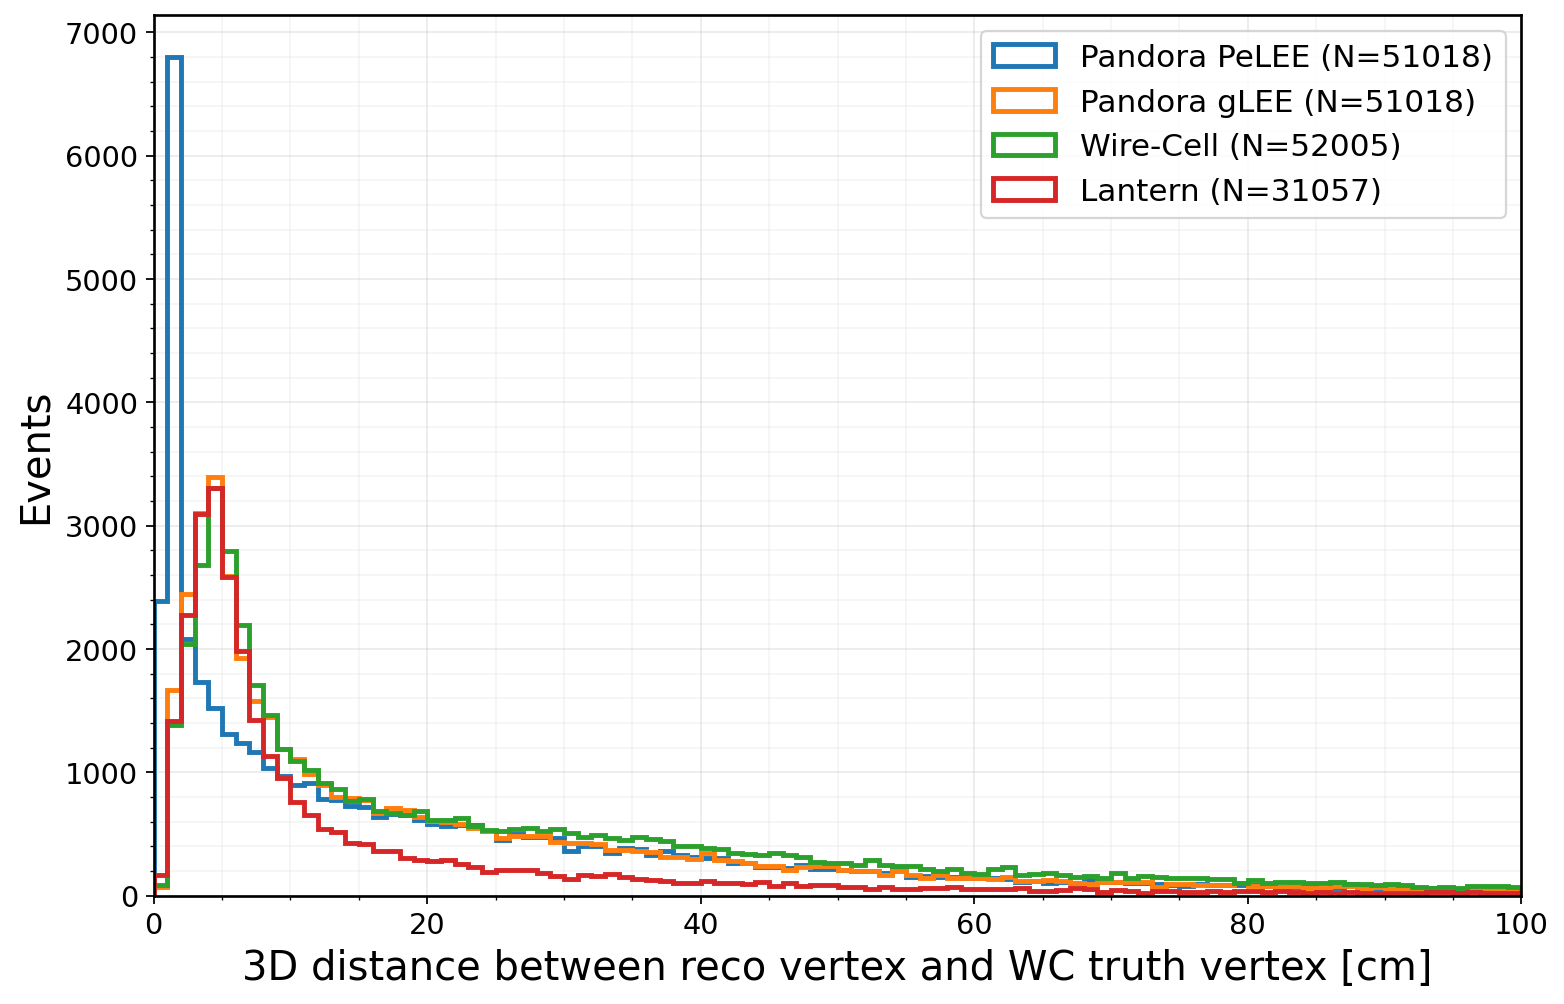

Saved: vertexRes_overlay_WCtruth_selNC1pi0_0p_FV-truth.png

--- Resolution summary (cm) ---
Pandora PeLEE : median= 16.75  p68= 35.10  p90=151.48
Pandora gLEE  : median= 17.12  p68= 35.03  p90=150.89
Wire-Cell     : median= 18.61  p68= 35.79  p90= 87.54
Lantern       : median=  7.45  p68= 14.73  p90= 58.13


In [23]:
# ============================================================
# Full code: compare vertex resolution across frameworks
# using the SAME Wire-Cell truth, with:
#   - physics selection mask (NC1pi0 0p, etc.)
#   - optional FV cut
#   - optional truth proton-energy cut
#   - sentinel removal for bad reco vertices
# ============================================================

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# ------------------------------------------------------------
# 0) Collect your merged dataframe (as you requested)
# ------------------------------------------------------------
presel_merged_df = presel_merged_df_allvars.select(load_vars).collect()

# ------------------------------------------------------------
# 1) Convert to pandas DataFrame called df
# ------------------------------------------------------------
df = presel_merged_df.to_pandas() if hasattr(presel_merged_df, "to_pandas") else presel_merged_df
if not isinstance(df, pd.DataFrame):
    df = pd.DataFrame(df)

print("Loaded df with shape:", df.shape)

# ============================================================
# 2) APPLY YOUR PHYSICS SELECTION MASK (pandas version)
#   normal_overlay & wc_truth_inFV & wc_truth_isNC &
#   ~wc_truth_NCDeltaRad & wc_truth_1pi0 & wc_truth_0p
# ============================================================

mask_cols = [
    "normal_overlay",
    "wc_truth_inFV",
    "wc_truth_isNC",
    "wc_truth_NCDeltaRad",
    "wc_truth_1pi0",
    "wc_truth_0p",
]
missing = [c for c in mask_cols if c not in df.columns]
if missing:
    raise KeyError(f"Missing selection columns in df: {missing}")

# Force booleans (safe if they are already bool or 0/1)
for c in mask_cols:
    if df[c].dtype != bool:
        df[c] = df[c].astype(bool)

mask_sel = (
    df["normal_overlay"] &
    df["wc_truth_inFV"] &
    df["wc_truth_isNC"] &
    ~df["wc_truth_NCDeltaRad"] &
    df["wc_truth_1pi0"] &
    df["wc_truth_0p"]
)

df_sel = df.loc[mask_sel].copy()
print(f"After selection: {len(df_sel)} / {len(df)} ({len(df_sel)/max(len(df),1):.4f})")

# ============================================================
# 3) CONFIG: set your exact column names here
# ============================================================

# --- Wire-Cell TRUTH vertex (reference truth for all frameworks)
WC_TRUTH = ["wc_truth_vtxX", "wc_truth_vtxY", "wc_truth_vtxZ"]  # EDIT if needed

# --- Reco vertices for each framework (EDIT to your exact names)
PELEE_RECO   = ["pandora_reco_nu_vtx_sce_x", "pandora_reco_nu_vtx_sce_y", "pandora_reco_nu_vtx_sce_z"]
GLEE_RECO    = ["glee_reco_vertex_x",       "glee_reco_vertex_y",       "glee_reco_vertex_z"]
WC_RECO      = ["wc_reco_nuvtxX",           "wc_reco_nuvtxY",           "wc_reco_nuvtxZ"]
LANTERN_RECO = ["lantern_vtxX",             "lantern_vtxY",             "lantern_vtxZ"]  # set None if not available

# --- Optional truth proton energy cut column (if you have it)
PROTON_E_COL = "wc_true_max_prim_proton_energy"  # EDIT if your name differs

# ============================================================
# 4) Switches
# ============================================================
COORD_ABS_MAX = 1e6

FV_MODE = "truth"         # "none" / "reco" / "truth" / "both"
APPLY_PROTON_CUT = False  # set True only if PROTON_E_COL exists & you want it
MAX_PROTON_E = 10.0

GOOD_RECO_MAX_CM = None   # e.g. 10.0 or None

# ============================================================
# 5) Fiducial volume (edit to yours)
# ============================================================
FV = {
    "x_min":  10.0,
    "x_max": 246.0,
    "y_min": -106.0,
    "y_max":  106.0,
    "z_min":  10.0,
    "z_max": 1036.0,
}

def in_fv(x, y, z, fv=FV):
    return (
        (x >= fv["x_min"]) & (x <= fv["x_max"]) &
        (y >= fv["y_min"]) & (y <= fv["y_max"]) &
        (z >= fv["z_min"]) & (z <= fv["z_max"])
    )

# ============================================================
# 6) Helper: remove sentinel reco vertices (framework-specific)
# ============================================================
def apply_reco_sentinel_mask(rx, ry, rz, sentinel_value=None, sentinel_abs=None):
    mask = np.ones_like(rx, dtype=bool)

    # exact triplet sentinel (e.g. -99999, -1, -999)
    if sentinel_value is not None:
        mask &= ~((rx == sentinel_value) & (ry == sentinel_value) & (rz == sentinel_value))

    # huge float sentinels (e.g. +/-3e38)
    if sentinel_abs is not None:
        mask &= (np.abs(rx) < sentinel_abs) & (np.abs(ry) < sentinel_abs) & (np.abs(rz) < sentinel_abs)

    return mask

# ============================================================
# 7) Core: dist(reco, WC truth) on df_sel with masks
# ============================================================
def compute_dist_vs_wc_truth(
    df_in,
    reco_cols,
    truth_cols,
    coord_abs_max=COORD_ABS_MAX,
    fv_mode="none",
    apply_proton_cut=False,
    max_proton_energy=10.0,
    proton_energy_col=PROTON_E_COL,
    good_reco_max_cm=None,
    reco_sentinel_value=None,
    reco_sentinel_abs=None,
):
    # check columns
    for c in reco_cols + truth_cols:
        if c not in df_in.columns:
            raise KeyError(f"Missing column: {c}")

    if apply_proton_cut and (proton_energy_col not in df_in.columns):
        raise KeyError(f"Missing proton energy column: {proton_energy_col}")

    rx = df_in[reco_cols[0]].to_numpy(dtype=np.float64)
    ry = df_in[reco_cols[1]].to_numpy(dtype=np.float64)
    rz = df_in[reco_cols[2]].to_numpy(dtype=np.float64)

    tx = df_in[truth_cols[0]].to_numpy(dtype=np.float64)
    ty = df_in[truth_cols[1]].to_numpy(dtype=np.float64)
    tz = df_in[truth_cols[2]].to_numpy(dtype=np.float64)

    # 1) finite + remove crazy placeholders by abs
    mask = (
        np.isfinite(rx) & np.isfinite(ry) & np.isfinite(rz) &
        np.isfinite(tx) & np.isfinite(ty) & np.isfinite(tz)
    )
    mask &= (np.abs(rx) < coord_abs_max) & (np.abs(ry) < coord_abs_max) & (np.abs(rz) < coord_abs_max)
    mask &= (np.abs(tx) < coord_abs_max) & (np.abs(ty) < coord_abs_max) & (np.abs(tz) < coord_abs_max)

    # 2) remove framework sentinel reco vertices
    mask &= apply_reco_sentinel_mask(rx, ry, rz, sentinel_value=reco_sentinel_value, sentinel_abs=reco_sentinel_abs)

    # 3) FV cut (applied to reco and/or truth)
    if fv_mode != "none":
        reco_in  = in_fv(rx, ry, rz)
        truth_in = in_fv(tx, ty, tz)

        if fv_mode == "reco":
            mask &= reco_in
        elif fv_mode == "truth":
            mask &= truth_in
        elif fv_mode == "both":
            mask &= (reco_in & truth_in)
        else:
            raise ValueError("FV_MODE must be one of: none, reco, truth, both")

    # 4) optional truth proton-energy cut (from WC truth info)
    if apply_proton_cut:
        pE = df_in[proton_energy_col].to_numpy(dtype=np.float64)
        mask &= np.isfinite(pE)
        mask &= (pE < max_proton_energy)

    # 5) distance
    dx = rx - tx
    dy = ry - ty
    dz = rz - tz
    dist = np.sqrt(dx*dx + dy*dy + dz*dz)

    # 6) optional good reco cut
    if good_reco_max_cm is not None:
        mask &= (dist <= good_reco_max_cm)

    return dist[mask], int(mask.sum()), len(df_in)

# ============================================================
# 8) Run each framework (all vs the same WC truth)
# ============================================================

frameworks = [
    ("Pandora PeLEE", PELEE_RECO,   dict(reco_sentinel_abs=1e20)),        # huge +/-3e38 style
    ("Pandora gLEE",  GLEE_RECO,    dict(reco_sentinel_value=-99999.0)),
    ("Wire-Cell",     WC_RECO,      dict(reco_sentinel_value=-1.0)),
]

if LANTERN_RECO is not None:
    # Your lantern mode was -999 => remove that triplet
    frameworks.append(("Lantern", LANTERN_RECO, dict(reco_sentinel_value=-999.0)))

# check truth cols exist in df_sel
for c in WC_TRUTH:
    if c not in df_sel.columns:
        raise KeyError(f"WC truth column not found in df_sel: {c}")

# if proton cut enabled, verify column
if APPLY_PROTON_CUT and (PROTON_E_COL not in df_sel.columns):
    raise KeyError(f"APPLY_PROTON_CUT=True but missing {PROTON_E_COL}")

dists = {}
counts = {}

for name, reco_cols, sent_kw in frameworks:
    # check reco cols exist
    for c in reco_cols:
        if c not in df_sel.columns:
            raise KeyError(f"{name}: missing reco column in df_sel: {c}")

    dist, kept, tot = compute_dist_vs_wc_truth(
        df_sel,
        reco_cols=reco_cols,
        truth_cols=WC_TRUTH,
        fv_mode=FV_MODE,
        apply_proton_cut=APPLY_PROTON_CUT,
        max_proton_energy=MAX_PROTON_E,
        proton_energy_col=PROTON_E_COL,
        good_reco_max_cm=GOOD_RECO_MAX_CM,
        **sent_kw
    )
    dists[name] = dist
    counts[name] = (kept, tot)
    print(f"{name} kept: {kept} / {tot}")

# ============================================================
# 9) Plot overlay
# ============================================================
plt.rcParams.update({
    "font.size": 14,
    "axes.labelsize": 18,
    "axes.titlesize": 20,
    "xtick.labelsize": 13,
    "ytick.labelsize": 13,
    "axes.linewidth": 1.2,
})

xmax = 100
bins = np.linspace(0, xmax, 101)

fig, ax = plt.subplots(figsize=(10, 6.5), dpi=160)

for name, _, _ in frameworks:
    ax.hist(
        dists[name],
        bins=bins,
        histtype="step",
        linewidth=2.2,
        label=f"{name} (N={len(dists[name])})"
    )

ax.set_xlabel("3D distance between reco vertex and WC truth vertex [cm]")
ax.set_ylabel("Events")
ax.set_xlim(0, xmax)

ax.grid(True, which="major", alpha=0.25)
ax.grid(True, which="minor", alpha=0.12)
ax.minorticks_on()

info = f"Selection: normal_overlay & WC truth NC1pi0 0p\nFV mode: {FV_MODE}"
if APPLY_PROTON_CUT:
    info += f"\nmax true prim p energy < {MAX_PROTON_E}"
if GOOD_RECO_MAX_CM is not None:
    info += f"\nkeep dist <= {GOOD_RECO_MAX_CM} cm"

# ax.text(
#     0.02, 0.98, info,
#     transform=ax.transAxes,
#     ha="left", va="top",
#     fontsize=11,
#     bbox=dict(boxstyle="round,pad=0.35", facecolor="white", alpha=0.9, linewidth=1.0),
# )

ax.legend(frameon=True, loc="upper right")
plt.tight_layout()

outname = f"vertexRes_overlay_WCtruth_selNC1pi0_0p_FV-{FV_MODE}.png"
plt.savefig(outname)
plt.show()

print("Saved:", outname)

# ============================================================
# 10) Quick numeric ranking
# ============================================================
print("\n--- Resolution summary (cm) ---")
for name, _, _ in frameworks:
    arr = dists[name]
    if len(arr) == 0:
        print(f"{name:14s}: no events after cuts")
        continue
    p50 = np.percentile(arr, 50)
    p68 = np.percentile(arr, 68)
    p90 = np.percentile(arr, 90)
    print(f"{name:14s}: median={p50:6.2f}  p68={p68:6.2f}  p90={p90:6.2f}")


In [ ]:
1/0

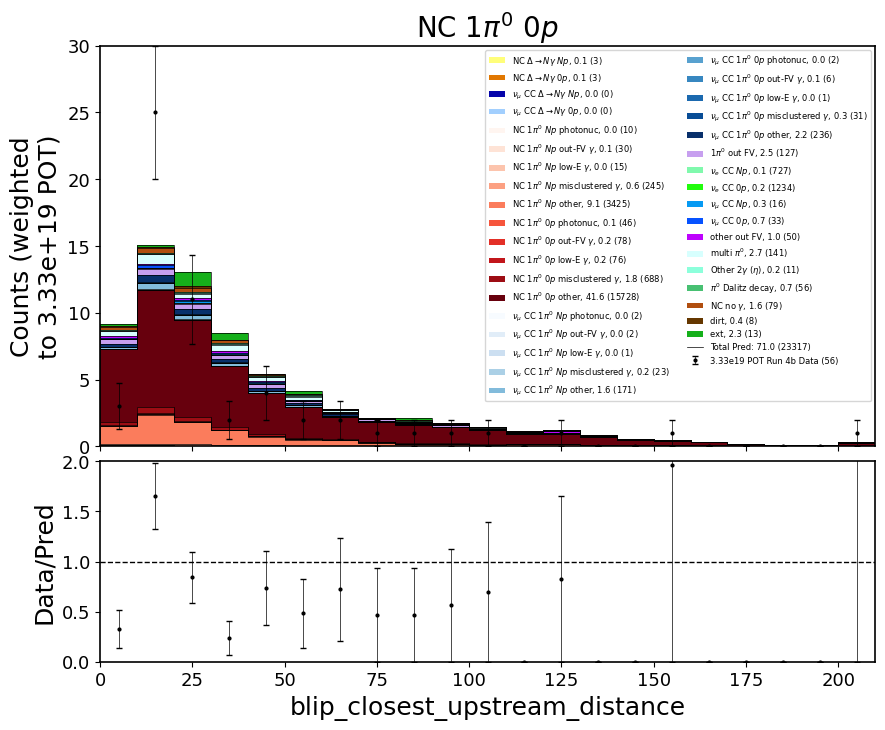

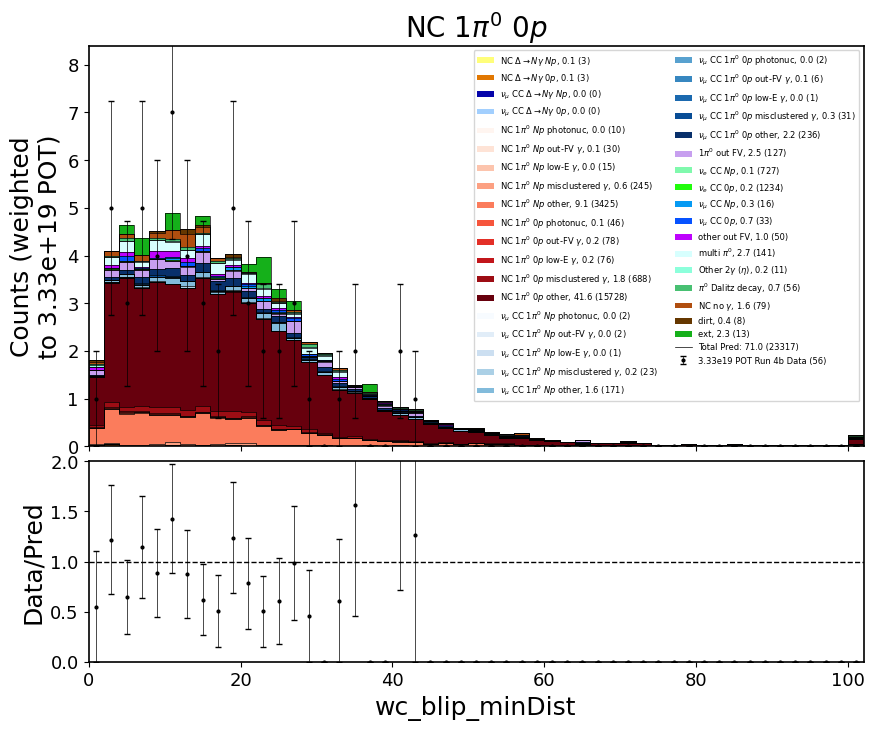

KeyboardInterrupt: 

In [24]:
presel_merged_df = presel_merged_df_allvars.select(load_vars).collect()

for reco_category in ["NC1pi0_0p"]:

    if reco_category == "preselection":
        sel_df = presel_merged_df
        reco_category_latex = "Preselection"

    elif reco_category in reco_categories:
        reco_category_i = reco_categories.index(reco_category)
        sel_df = presel_merged_df.filter(reco_category_queries[reco_category_i])
        reco_category_latex = reco_category_labels_latex[reco_category_i]

    else:
        raise ValueError(f"Invalid selection type: {reco_category}")

    for var, bins in [

        # -----------------------------
        # Existing upstream blip variable
        # -----------------------------
        ("blip_closest_upstream_distance", np.linspace(0, 200, 21)),

        # -----------------------------
        # WC vertex → blips
        # -----------------------------
        ("wc_blip_minDist", np.linspace(0, 100, 51)),
        ("wc_blip_minDist_energy", np.linspace(0, 10, 21)),
        ("wc_blip_nWithin_5cm", np.arange(-0.5, 30.5, 1.0)),
        ("wc_blip_nWithin_10cm", np.arange(-0.5, 30.5, 1.0)),
        ("wc_blip_nWithin_30cm", np.arange(-0.5, 50.5, 1.0)),
        ("wc_blip_nWithin_50cm", np.arange(-0.5, 80.5, 1.0)),
        ("wc_blip_nWithin_75cm", np.arange(-0.5, 120.5, 1.0)),
        ("wc_blip_nWithin_100cm", np.arange(-0.5, 160.5, 1.0)),

        # -----------------------------
        # Pandora (peLEE) vertex → blips
        # -----------------------------
        ("pandora_pelee_blip_minDist", np.linspace(0, 100, 51)),
        ("pandora_pelee_blip_minDist_energy", np.linspace(0, 10, 21)),
        ("pandora_pelee_blip_nWithin_5cm", np.arange(-0.5, 30.5, 1.0)),
        ("pandora_pelee_blip_nWithin_10cm", np.arange(-0.5, 30.5, 1.0)),
        ("pandora_pelee_blip_nWithin_30cm", np.arange(-0.5, 50.5, 1.0)),
        ("pandora_pelee_blip_nWithin_50cm", np.arange(-0.5, 80.5, 1.0)),
        ("pandora_pelee_blip_nWithin_75cm", np.arange(-0.5, 120.5, 1.0)),
        ("pandora_pelee_blip_nWithin_100cm", np.arange(-0.5, 160.5, 1.0)),

        # -----------------------------
        # Pandora (gLEE) vertex → blips
        # -----------------------------
        ("pandora_glee_blip_minDist", np.linspace(0, 100, 51)),
        ("pandora_glee_blip_minDist_energy", np.linspace(0, 10, 21)),
        ("pandora_glee_blip_nWithin_5cm", np.arange(-0.5, 30.5, 1.0)),
        ("pandora_glee_blip_nWithin_10cm", np.arange(-0.5, 30.5, 1.0)),
        ("pandora_glee_blip_nWithin_30cm", np.arange(-0.5, 50.5, 1.0)),
        ("pandora_glee_blip_nWithin_50cm", np.arange(-0.5, 80.5, 1.0)),
        ("pandora_glee_blip_nWithin_75cm", np.arange(-0.5, 120.5, 1.0)),
        ("pandora_glee_blip_nWithin_100cm", np.arange(-0.5, 160.5, 1.0)),

        # -----------------------------
        # LANTERN vertex → blips
        # -----------------------------
        ("lantern_blip_minDist", np.linspace(0, 100, 51)),
        ("lantern_blip_minDist_energy", np.linspace(0, 10, 21)),
        ("lantern_blip_nWithin_5cm", np.arange(-0.5, 30.5, 1.0)),
        ("lantern_blip_nWithin_10cm", np.arange(-0.5, 30.5, 1.0)),
        ("lantern_blip_nWithin_30cm", np.arange(-0.5, 50.5, 1.0)),
        ("lantern_blip_nWithin_50cm", np.arange(-0.5, 80.5, 1.0)),
        ("lantern_blip_nWithin_75cm", np.arange(-0.5, 120.5, 1.0)),
        ("lantern_blip_nWithin_100cm", np.arange(-0.5, 160.5, 1.0)),

    ]:

        make_histogram_plot(
            pred_and_data_sel_df=sel_df,
            bins=bins,
            var=var,
            display_var=var,
            title=reco_category_latex,
        )



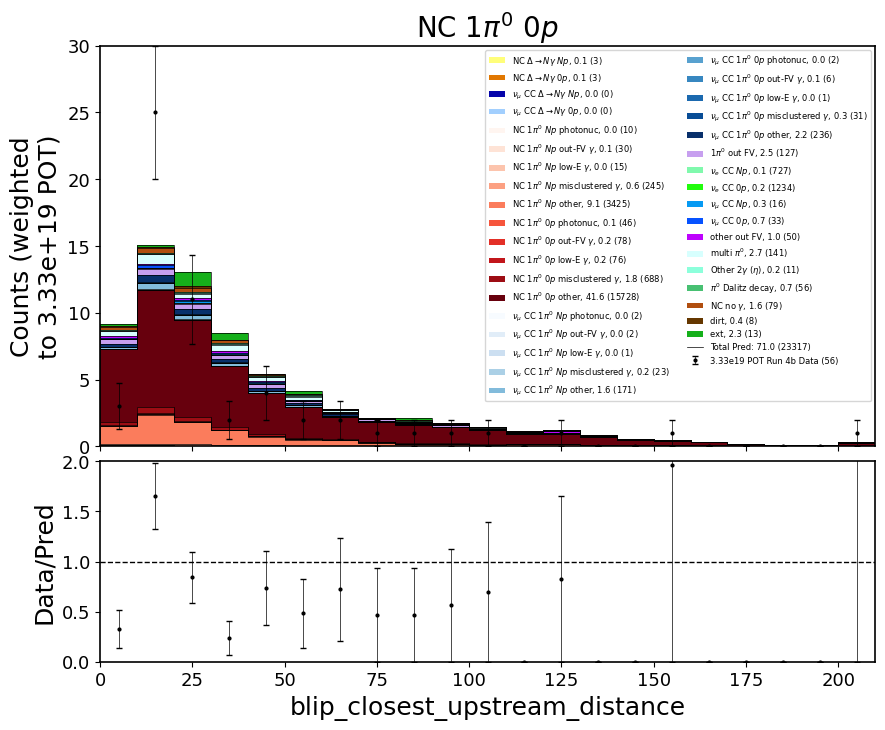

In [ ]:
presel_merged_df = presel_merged_df_allvars.select(load_vars).collect()
for reco_category in ["NC1pi0_0p"]:
    if reco_category == "preselection":
        sel_df = presel_merged_df
        reco_category_latex = "Preselection"
    elif reco_category in reco_categories:
        reco_category_i = reco_categories.index(reco_category)
        sel_df = presel_merged_df.filter(reco_category_queries[reco_category_i])
        reco_category_latex = reco_category_labels_latex[reco_category_i]
    else:
        raise ValueError(f"Invalid selection type: {reco_category}")

    for var, bins in [
            ("blip_closest_upstream_distance", np.linspace(0, 200, 21)),
            
            #("blip_closest_upstream_angle", np.linspace(0, 90, 19)),
            #("blip_closest_upstream_impact_parameter", np.linspace(0, 200, 21)),
            #("blip_closest_upstream_energy", np.linspace(0, 20, 21)),
            #("blip_closest_upstream_dx", np.linspace(0, 5, 11)),
        ]:

        make_histogram_plot(pred_and_data_sel_df=sel_df, bins=bins, var=var, display_var=var, title=reco_category_latex)
    

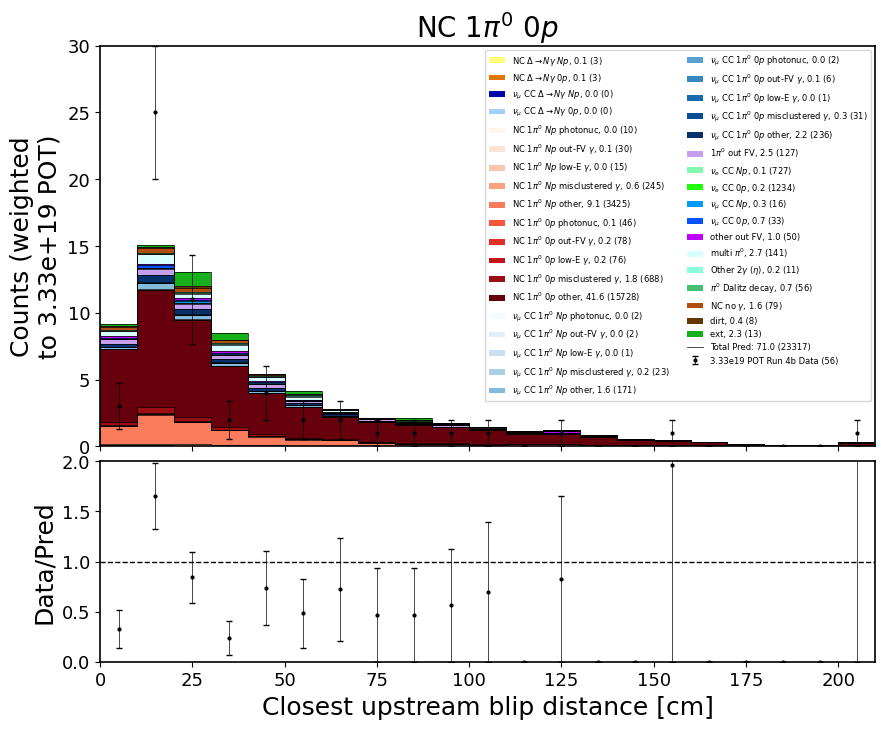

ColumnNotFoundError: "wc_vtx_blip_minDist" not found

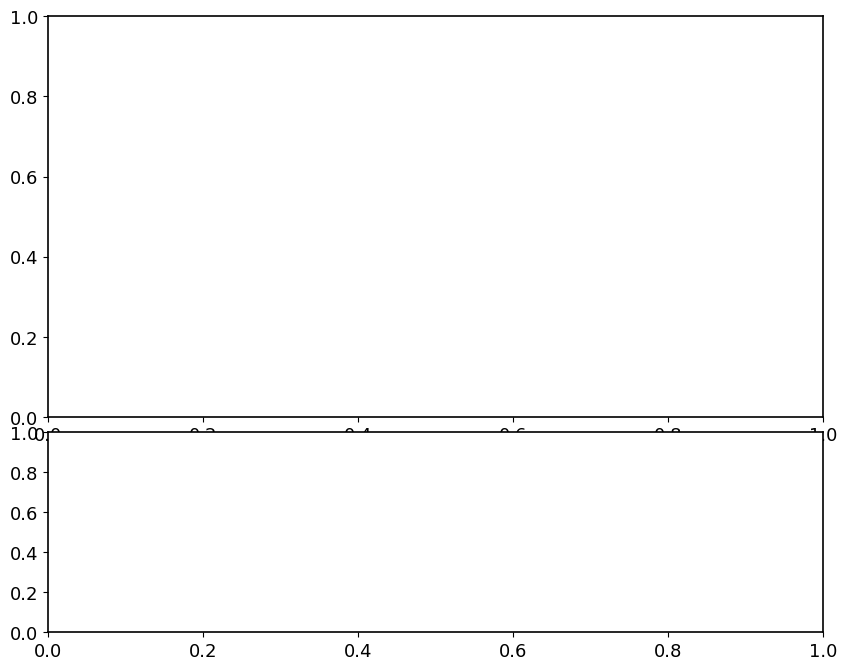

In [ ]:


for reco_category in ["NC1pi0_0p"]:

    if reco_category == "preselection":
        sel_df = presel_merged_df
        reco_category_latex = "Preselection"

    elif reco_category in reco_categories:
        reco_category_i = reco_categories.index(reco_category)
        sel_df = presel_merged_df.filter(reco_category_queries[reco_category_i])
        reco_category_latex = reco_category_labels_latex[reco_category_i]

    else:
        raise ValueError(f"Invalid selection type: {reco_category}")

    # -----------------------------------
    # Variables to plot
    # -----------------------------------
    for var, bins, display_var in [
        # Existing upstream-shower variable
        ("blip_closest_upstream_distance", np.linspace(0, 200, 21),
         r"Closest upstream blip distance [cm]"),

        # NEW: WC vertex → blip variables
        ("wc_vtx_blip_minDist", np.linspace(0, 50, 26),
         r"Closest blip distance to WC vertex [cm]"),

        ("wc_vtx_blip_minDist_energy", np.linspace(0, 10, 21),
         r"Energy of closest blip to WC vertex [MeV]"),

        ("wc_vtx_blip_nWithin10cm", np.arange(-0.5, 10.5, 1.0),
         r"Number of blips within 10 cm of WC vertex"),
    ]:

        make_histogram_plot(
            pred_and_data_sel_df=sel_df,
            bins=bins,
            var=var,
            display_var=display_var,
            title=reco_category_latex,
        )

In [ ]:
print(1/0)

In [ ]:
presel_detvar_df = pl.read_parquet(f"{intermediate_files_location}/detvar_presel_df_train_vars.parquet")

x = presel_detvar_df.select(training_vars).to_numpy()
x = x.astype(np.float64)
x[np.isinf(x)] = np.nan

# load xgboost model from f"../training_outputs/{training}/bdt.json")
# model.get_booster().save_model(output_dir / "bdt.json")

model = xgb.XGBClassifier()
model.load_model(f"../training_outputs/{training}/bdt.json")

all_probabilities = model.predict_proba(x)

num_probabilities = all_probabilities.shape[1]
for i in tqdm(range(num_probabilities)):
    presel_detvar_df = presel_detvar_df.with_columns(pl.DataFrame({
        f'prob_{train_category_labels[i]}': all_probabilities[:, i]
    }))


FileNotFoundError: No such file or directory (os error 2): /nevis/riverside/data/karan/ngem/intermediate_file/detvar_presel_df_train_vars.parquet

This error occurred with the following context stack:
	[1] 'parquet scan'
	[2] 'sink'


# Preselection Histogram

In [ ]:
# load columns from presel_merged_df
load_vars = list(presel_merged_df_allvars.collect_schema().names())

# remove columns combined_training_vars variables, tons of variables that aren't needed
load_vars = [col for col in load_vars if not (col in combined_training_vars)]

# TEMPORARY, since we didn't exclude all the pandora postprocessing variables
#load_vars = [col for col in load_vars if not (["pandora_max" in col])]

extra_vars = [
    "wc_kine_reco_Enu",
    "wc_reco_num_protons_35_MeV",
    "wc_reco_backwards_projected_dist",
    "wc_reco_distance_to_boundary",
    "wc_reco_shower_theta",
    "wc_reco_shower_phi",
    "wc_kine_pio_mass",
    "lantern_diphoton_mass",
]

# add back in the current variable
for var in extra_vars:
    if var not in load_vars:
        load_vars.append(var)

print(load_vars)

In [ ]:
presel_merged_df = presel_merged_df_allvars.select(load_vars).collect()

make_histogram_plot(pred_and_data_sel_df=presel_merged_df, bins=np.linspace(0, 2000, 21), 
            var="wc_kine_reco_Enu", display_var=r"WC Reconstructed $E_\nu$ (MeV)", title="Preselection",

            include_ratio=True, include_decomposition=True,

            selname="generic_presel",
            dont_load_rw_from_systematic_cache=False, dont_load_detvar_from_systematic_cache=False, 
            use_rw_systematics=True, use_detvar_systematics=True, use_detvar_bootstrapping=True, detvar_df=presel_detvar_df,

            plot_det_variations=True,

            plot_sys_breakdown=True, 
            #include_data_stat=False, include_pred_stat=False, include_total=False, just_genie_breakdown=False, include_rw=False,
            #just_detvar_breakdown=True,
            #print_sys_breakdown=False,
            )


# Grid Plot Cuts

In [ ]:
name_expr_priority_vals_w_None = [
    ("1gNp", pl.col("prob_1gNp") > 0.3, 1),
    ("1g0p", pl.col("prob_1g0p") > 0.9, 2),
    ("1gNp1mu", pl.col("prob_1gNp1mu") > 0.5, 3),
    ("1g0p1mu", pl.col("prob_1g0p1mu") > 0.2, 4),
    ("1g_outFV", pl.col("prob_1g_outFV") > 0.5, 5),
    ("NC1pi0_Np", None, 6),
    ("NC1pi0_0p", None, 7),
    ("numuCC1pi0_Np", pl.col("prob_numuCC1pi0_Np") > 0.1, 9),
    ("numuCC1pi0_0p", pl.col("prob_numuCC1pi0_0p") > 0.15, 8), # 0p takes priority over Np in orthogonality
    ("1pi0_outFV", pl.col("prob_1pi0_outFV") > 0.1, 10),
    ("nueCC_Np", pl.col("prob_nueCC_Np") > 0.05, 12),
    ("nueCC_0p", pl.col("prob_nueCC_0p") > 0.05, 11), # 0p takes priority over Np in orthogonality
    ("numuCC_Np", pl.col("prob_numuCC_Np") > 0.5, 13),
    ("numuCC_0p", pl.col("prob_numuCC_0p") > 0.5, 14),
    ("other_outFV_dirt", None, 15),
    ("multi_pi0", pl.col("prob_multi_pi0") > 0.02, 16),
    ("eta_other", pl.col("prob_eta_other") > 0.01, 17),
    ("pi0_dalitz_decay", pl.col("prob_pi0_dalitz_decay") > 0.1, 5.5), # high priority for dalitz, rare topology
    ("NC_no_gamma", None, 19),
    ("ext", None, 20),
]

name_expr_priority_vals_possible_overlap = []
for i, name_expr_priority_val_w_None in enumerate(name_expr_priority_vals_w_None):
    name, expr, priority = name_expr_priority_val_w_None
    if expr is None:
        expr = reco_category_argmax_queries[i]
    name_expr_priority_vals_possible_overlap.append((name, expr, priority))

name_expr_priority_vals_possible_overlap.sort(key=lambda x: x[2])

name_expr_priority_vals = []
for i, name_expr_priority_val_possible_overlap in enumerate(name_expr_priority_vals_possible_overlap):
    name, expr, priority = name_expr_priority_val_possible_overlap
    for j in range(i):
        expr = expr & ~name_expr_priority_vals_possible_overlap[j][1]
    name_expr_priority_vals.append((name, expr, priority))

reco_category_query_dic = {}
for name, expr, priority in name_expr_priority_vals:
    reco_category_query_dic[name] = expr

reco_category_queries = []
for reco_category in reco_categories:
    reco_category_queries.append(reco_category_query_dic[reco_category])

#for query in reco_category_queries:
#    print("\n", query)

# saving this to a file so we can apply the same cuts in the efficiency plots
with open(f"{intermediate_files_location}/reco_category_queries.pkl", "wb") as f:
    pickle.dump(reco_category_queries, f)


# BDT Score Plots

In [ ]:
#for category in ["pi0_dalitz_decay", "1gNp", "1g0p", "1gNp1mu", "1g0p1mu", "nueCC_Np", "nueCC_0p"]:
for category in ["1gNp", "1g0p", "1gNp1mu", "1g0p1mu", "pi0_dalitz_decay"]:
    make_histogram_plot(pred_and_data_sel_df=presel_merged_df, bins=np.linspace(0, 1, 21), var=f"prob_{category}", title="Preselection", log_y=True, include_ratio=False)


# Topology Grid Histograms

In [ ]:
do_grid = True

iso1g_norm_factor = None
del1g_norm_factor = None

do_full_pred_grid = False
include_data = True

# temporary
#do_full_pred_grid = True
#include_data = False

if do_grid:

    additional_scaling_factor = 1

    breakdown_queries = []
    for i in range(len(del1g_detailed_category_labels)):
        breakdown_queries.append(pl.col('del1g_detailed_signal_category') == i)
    breakdown_labels = del1g_detailed_category_labels
    breakdown_labels_latex = del1g_detailed_category_labels_latex
    breakdown_colors = del1g_detailed_category_colors
    breakdown_hatches = del1g_detailed_category_hatches

    if do_full_pred_grid:
        additional_scaling_factor = 1.11e21 / 3.33e19
        """breakdown_queries = []
        for i in range(len(del1g_simple_category_labels)):
            breakdown_queries.append(pl.col('del1g_simple_signal_category') == i)
        breakdown_labels = del1g_simple_category_labels
        breakdown_labels_latex = del1g_simple_category_labels_latex
        breakdown_colors = del1g_simple_category_colors
        breakdown_hatches = del1g_simple_category_hatches"""

    fig, axs = plt.subplots(7, 5, figsize=(20, 20))
    axs = axs.flatten()

    bins = np.linspace(0, 2000, 21)
    bin_centers = (bins[:-1] + bins[1:]) / 2

    for i in tqdm(range(len(reco_categories))):

        signal_category = reco_categories[i]
        signal_category_latex = reco_category_labels_latex[i]

        sel_df = presel_merged_df.filter(reco_category_queries[i])

        pred_sel_df = sel_df.filter(pl.col("filetype") != "data")
        data_sel_df = sel_df.filter(pl.col("filetype") == "data")

        breakdown_counts = []
        for breakdown_i, breakdown_label in enumerate(breakdown_labels):
            curr_df = pred_sel_df.filter(breakdown_queries[breakdown_i])
            breakdown_counts.append(np.histogram(curr_df.select("wc_kine_reco_Enu").to_numpy(), 
                                              weights=curr_df.select("wc_net_weight").to_numpy()*additional_scaling_factor, 
                                              bins=bins)[0])
        data_counts = np.histogram(data_sel_df.select("wc_kine_reco_Enu").to_numpy().flatten(), bins=bins)[0]

        axnum = i

        bottom = np.zeros(len(bins)-1)
        for breakdown_i, (breakdown_label, breakdown_count, breakdown_color, breakdown_hatch, breakdown_label_latex) in enumerate(zip(breakdown_labels, breakdown_counts, breakdown_colors, breakdown_hatches, breakdown_labels_latex)):
            if "iso1g" in breakdown_label:
                if iso1g_norm_factor == None:
                    continue
                breakdown_count = breakdown_count * iso1g_norm_factor
            elif "del1g" in breakdown_label:
                if del1g_norm_factor == None:
                    continue
                breakdown_count = breakdown_count * del1g_norm_factor
            elif "data" in breakdown_label:
                continue

            n, _, _ = axs[axnum].hist(bin_centers, weights=breakdown_count, bins=bins, bottom=bottom if breakdown_i > 0 else None, color=breakdown_color, hatch=breakdown_hatch, label=breakdown_label_latex)
            axs[axnum].hist(bin_centers, weights=breakdown_count, bins=bins, bottom=bottom if breakdown_i > 0 else None, histtype="step", color="k", lw=0.5)

            if breakdown_i == 0:
                bottom = n
            else:
                bottom += n

        #print(signal_category, np.sum(breakdown_counts))

        if include_data:
            axs[axnum].errorbar(bin_centers, data_counts, yerr=np.sqrt(data_counts), fmt="o", color="k", lw=0.5, capsize=2, capthick=1, markersize=2, label="3.33e19 POT Run 4b Data")

        max_pred = np.max(bottom)
        max_data = np.max(data_counts)

        axs[axnum].set_ylim(0, max(max_pred, max_data) * 1.1)

        if axnum == 19:
            axs[axnum].legend(ncol=4, loc='upper right', bbox_to_anchor=(-1, -0.5))

        if axnum in [15, 16, 17, 18, 19]:
            axs[axnum].set_xlabel(r"WC Reconstructed $E_\nu$ (MeV)")
        if axnum % 5 == 0: # Only show y-label for leftmost column
            if additional_scaling_factor != 1.0:
                axs[axnum].set_ylabel(f"Counts (weighted\nto {additional_scaling_factor*3.33e19:.2e} POT)")
            else:
                axs[axnum].set_ylabel("Counts (weighted\nto 3.33e19 POT)")
        axs[axnum].set_title(f"{signal_category_latex} Selection")
        axs[axnum].set_xlim(0, 2000)

    for axnum in range(len(axs)):
        if axnum > 19:
            axs[axnum].remove()

    fig.subplots_adjust(hspace=0.5, wspace=0.3, bottom=0.15)

    plt.savefig(f"../plots/multiclass_histograms_{training}.pdf")
    plt.savefig(f"../plots/multiclass_histograms_{training}.png")
    plt.show()


# One Shower Plots

## Multi-class BDT

In [ ]:
for reco_category in ["pi0_dalitz_decay", "1gNp", "1g0p", "1gNp1mu", "1g0p1mu", "nueCC_Np", "nueCC_0p"]:
    reco_category_i = reco_categories.index(reco_category)
    reco_category_latex = reco_category_labels_latex[reco_category_i]

    sel_df = presel_merged_df.filter(reco_category_queries[reco_category_i])

    make_histogram_plot(pred_and_data_sel_df=sel_df, bins=np.linspace(0, 3000, 31), var="wc_kine_reco_Enu", display_var=r"WC Reconstructed $E_\nu$ (MeV)", title=reco_category_latex, include_ratio=False)


## Older 1g selections

In [ ]:
for reco_category in ["NCDeltaRad_1gNp", "NCDeltaRad_1g0p", "erin_inclusive_1g", "WC_nueCC_Np", "WC_nueCC_0p"]:
    
    if reco_category == "presel":
        sel_df = presel_merged_df
        reco_category_latex = "Preselection"
    elif reco_category == "NCDeltaRad_1gNp":
        sel_df = presel_merged_df.filter(
            (pl.col("wc_kine_reco_Enu") > 0) & 
            (pl.col("wc_nc_delta_score") > 2.61) & 
            (pl.col("wc_reco_num_protons_35_MeV") > 0)
        )
        reco_category_latex = r"NC $\Delta\rightarrow N\gamma$ $Np$"
    elif reco_category == "NCDeltaRad_1g0p":
        sel_df = presel_merged_df.filter(
            (pl.col("wc_kine_reco_Enu") > 0) & 
            (pl.col("wc_nc_delta_score") > 2.61) & 
            (pl.col("wc_reco_num_protons_35_MeV") == 0)
        )
        reco_category_latex = r"NC $\Delta\rightarrow N\gamma$ $0p$"
    elif reco_category == "erin_inclusive_1g":
        sel_df = presel_merged_df.filter(pl.col("erin_inclusive_1g_sel") == 1)
        reco_category_latex = r"Erin Inclusive $1g$"
    elif reco_category == "WC_nueCC_Np":
        sel_df = presel_merged_df.filter(
            (pl.col("wc_nue_score") > 7) & 
            (pl.col("wc_kine_reco_Enu") > 0) & 
            (pl.col("wc_reco_num_protons_35_MeV") > 0)
        )
        reco_category_latex = r"WC $\nu_e$CC $Np$"
    elif reco_category == "WC_nueCC_0p":
        sel_df = presel_merged_df.filter(
            (pl.col("wc_nue_score") > 7) & 
            (pl.col("wc_kine_reco_Enu") > 0) & 
            (pl.col("wc_reco_num_protons_35_MeV") == 0)
        )
        reco_category_latex = r"WC $\nu_e$CC $0p$"
    
    make_histogram_plot(pred_and_data_sel_df=sel_df, bins=np.linspace(0, 3000, 31), var="wc_kine_reco_Enu", display_var=r"WC Reconstructed $E_\nu$ (MeV)", 
    title=reco_category_latex, include_ratio=False)


# Post-Selection Studies

## Backward Projected Distance

In [ ]:
for reco_category in ["preselection", "1g0p", "other_outFV_dirt"]:

    if reco_category == "preselection":
        sel_df = presel_merged_df
        reco_category_latex = "Preselection"
    elif reco_category in reco_categories:
        reco_category_i = reco_categories.index(reco_category)
        sel_df = presel_merged_df.filter(reco_category_queries[reco_category_i])
        reco_category_latex = reco_category_labels_latex[reco_category_i]
    else:
        raise ValueError(f"Invalid selection type: {reco_category}")

    for var, bins in [
            ("wc_reco_backwards_projected_dist", np.linspace(-100, 2000, 43)),
            ("wc_reco_distance_to_boundary", np.linspace(0, 150, 31)), 
            ("wc_reco_shower_theta", np.linspace(0, 180, 19)),
            ("wc_reco_shower_phi", np.linspace(-180, 180, 19)),
        ]:

        make_histogram_plot(pred_and_data_sel_df=sel_df, bins=bins, var=var, display_var=var, title=reco_category_latex)

## Di-photon Invariant Mass

In [ ]:
for reco_category in ["NC1pi0_Np", "NC1pi0_0p", "eta_other"]:
    if reco_category in reco_categories:
        reco_category_i = reco_categories.index(reco_category)
        sel_df = presel_merged_df.filter(reco_category_queries[reco_category_i])
        pred_sel_df = sel_df.filter(pl.col("filetype") != "data")
        data_sel_df = sel_df.filter(pl.col("filetype") == "data")
        reco_category_latex = reco_category_labels_latex[reco_category_i]
    else:
        raise ValueError(f"Invalid selection type: {reco_category}")

    for var, bins in [
            ("wc_kine_pio_mass", np.linspace(0, 1000, 41)),
            ("lantern_diphoton_mass", np.linspace(0, 1000, 41)), 
            #("wc_kine_pio_angle", np.linspace(0, 180, 19)),
            #("lantern_diphoton_opening_angle", np.linspace(0, 180, 19)),
            #("wc_kine_pio_energy_1", np.linspace(0, 1000, 21)),
            #("lantern_diphoton_energy", np.linspace(0, 100000, 21)),
        ]:

        make_histogram_plot(pred_sel_df=pred_sel_df, data_sel_df=data_sel_df, bins=bins, var=var, display_var=var, title=reco_category_latex)

    plt.figure(figsize=(10, 10))
    plt.hist2d(pred_sel_df.select("lantern_diphoton_mass").to_numpy().flatten(), pred_sel_df.select("wc_kine_pio_mass").to_numpy().flatten(), 
                    weights=pred_sel_df.select("wc_net_weight").to_numpy().flatten(), 
                    bins=np.linspace(0, 1000, 41))
    plt.colorbar()
    plt.xlabel("Lantern Diphoton Mass (MeV)")
    plt.ylabel("WC Diphoton Mass (MeV)")
    plt.title(reco_category_latex + " Prediction")
    plt.show()
    

## Blips

In [ ]:
for reco_category in ["preselection", "1gNp", "1g0p"]:
    if reco_category == "preselection":
        sel_df = presel_merged_df
        reco_category_latex = "Preselection"
    elif reco_category in reco_categories:
        reco_category_i = reco_categories.index(reco_category)
        sel_df = presel_merged_df.filter(reco_category_queries[reco_category_i])
        reco_category_latex = reco_category_labels_latex[reco_category_i]
    else:
        raise ValueError(f"Invalid selection type: {reco_category}")

    for var, bins in [
            ("blip_closest_upstream_distance", np.linspace(0, 200, 21)),
            #("blip_closest_upstream_angle", np.linspace(0, 90, 19)),
            #("blip_closest_upstream_impact_parameter", np.linspace(0, 200, 21)),
            #("blip_closest_upstream_energy", np.linspace(0, 20, 21)),
            #("blip_closest_upstream_dx", np.linspace(0, 5, 11)),
        ]:

        make_histogram_plot(pred_and_data_sel_df=sel_df, bins=bins, var=var, display_var=var, title=reco_category_latex)
    

## Nanosecond Timing

In [ ]:
# related to https://github.com/brb-rightback/ns_demo_MCC9.10/blob/main/ns_demo_MCC9.10.ipynb
# TODO: Validate this with data and showers, see https://microboone-docdb.fnal.gov/cgi-bin/sso/ShowDocument?docid=44781
# Also check the manually applied shifts for all the different time periods

beamon_presel_merged_df = presel_merged_df.filter(pl.col("filetype") == "data")
beamoff_presel_merged_df = presel_merged_df.filter(pl.col("filetype") == "ext") 
mc_presel_merged_df = presel_merged_df.filter(~pl.col("filetype").is_in(["data", "ext"]))

beamoff_presel_merged_df = beamoff_presel_merged_df.with_columns(pl.col("wc_evtTimeNS").alias("non_merge_time"))
beamon_presel_merged_df = beamon_presel_merged_df.with_columns((pl.col("wc_evtTimeNS") + 5700).alias("non_merge_time"))
mc_presel_merged_df = mc_presel_merged_df.with_columns((pl.col("wc_evtTimeNS_cor") + 1500).alias("non_merge_time")) # manually shifting MC to approximately match data

data_presel_merged_df = pl.concat([beamoff_presel_merged_df, beamon_presel_merged_df])
del beamoff_presel_merged_df
del beamon_presel_merged_df

def calc_merge_time_data(run, evt_time):
    gap = 18.936
    if run >= 19500:
        shift = 2920.5
    elif run >= 17380:
        shift = 2916.0
    elif run >= 13697:
        shift = 3147.3
    elif run >= 10812:
        shift = 3568.5
    elif run >= 8321:
        shift = 3610.7
    elif run >= 5800:
        shift = 3164.4
    else:
        shift = 3168.9
        
    tt_help = evt_time - shift + gap * 0.5
    if np.isinf(tt_help):
        tt_help = float('nan')
    
    if tt_help >= 0:
        return (tt_help - (int(tt_help/gap) * gap)) - gap * 0.5
    return -9999.

data_presel_merged_df = data_presel_merged_df.with_columns(
    pl.struct(["run", "wc_evtTimeNS"]).map_elements(lambda x: calc_merge_time_data(x["run"], x["wc_evtTimeNS"])).alias("merge_time")
)

def calc_merge_time_mc(evt_time):
    gap = 18.936
    shift = 5.8 - 0.3
    
    tt_help = np.nan_to_num(evt_time - shift + gap * 0.5, nan=-9999)
    
    if tt_help >= 0:
        return (tt_help - (int(tt_help/gap) * gap)) - gap * 0.5
    return -9999.

mc_presel_merged_df = mc_presel_merged_df.with_columns(
    pl.col("wc_evtTimeNS_cor").map_elements(calc_merge_time_mc).alias("merge_time")
)

presel_merged_df = pl.concat([mc_presel_merged_df, data_presel_merged_df])
del mc_presel_merged_df
del data_presel_merged_df


In [ ]:
for reco_category in ["preselection", "1gNp", "1g0p", "other_outFV_dirt", "other_outFV_dirt_downstream"]:
    if reco_category == "preselection":
        sel_df = presel_merged_df
        reco_category_latex = "Preselection"
    elif reco_category in reco_categories:
        reco_category_i = reco_categories.index(reco_category)
        sel_df = presel_merged_df.filter(reco_category_queries[reco_category_i])
        reco_category_latex = reco_category_labels_latex[reco_category_i]
    elif reco_category == "other_outFV_dirt_downstream":
        reco_category_i = reco_categories.index("other_outFV_dirt")
        sel_df = presel_merged_df.filter(reco_category_queries[reco_category_i]).filter(pl.col("wc_reco_nuvtxZ") > 500)
        reco_category_latex = r"Other OutFV/Dirt Downstream"
    else:
        raise ValueError(f"Invalid selection type: {reco_category}")

    make_histogram_plot(pred_and_data_sel_df=sel_df, bins=np.linspace(8500, 11000, 21), var="non_merge_time", display_var="Time in Spill (ns)\n(WARNING: Fudge Factors Included)", title=reco_category_latex)
    make_histogram_plot(pred_and_data_sel_df=sel_df, bins=np.linspace(-9.462531250000058, 9.462531250000058, 21), var="merge_time", display_var="Time in Bunch (ns)", title=reco_category_latex)


## Out-TPC PMT Veto

In [ ]:
for reco_category in ["preselection", "1gNp", "1g0p", "other_outFV_dirt"]:

    if reco_category == "preselection":
        sel_df = presel_merged_df
        reco_category_latex = "Preselection"
    elif reco_category in reco_categories:
        reco_category_i = reco_categories.index(reco_category)
        sel_df = presel_merged_df.filter(reco_category_queries[reco_category_i])
        reco_category_latex = reco_category_labels_latex[reco_category_i]
    else:
        raise ValueError(f"Invalid selection type: {reco_category}")

    make_histogram_plot(pred_and_data_sel_df=sel_df, bins=np.linspace(-1, 5, 21), var="(wc_flash_measPe - wc_flash_predPe) / wc_flash_predPe", display_var="(meas - pred) / pred light", title=reco_category_latex)
    make_histogram_plot(pred_and_data_sel_df=sel_df, bins=np.linspace(-1, 10, 51), var="wc_WCPMTInfoChi2 / wc_WCPMTInfoNDF", display_var="WC Flash chi2/ndf\n(WARNING: Missing PMT Info for some files, set to -1)", title=reco_category_latex, log_y=True)


## Out-TPC CRT Veto

In [ ]:
# TODO: Look at CRT information, and if we can identify in-time out-TPC activity associated with an event
# (even if there's no clean CRT track indicating a through-going cosmic muon)


# Out-TPC Geometric BDT

In [ ]:
# TODO: Look at just shower position and direction, use that to separate in-FV vs out-FV reco-1g events


## Spacepoint SSV

In [ ]:
# TODO: https://github.com/leehagaman/spacepoint_ssv
# Will require processing ntuples with all cosmic spacepoints turned on


In [ ]:
for reco_category in ["preselection", "1gNp", "1g0p"]:

    if reco_category == "preselection":
        sel_df = presel_merged_df
        reco_category_latex = "Preselection"

    elif reco_category in reco_categories:
        reco_category_i = reco_categories.index(reco_category)
        sel_df = presel_merged_df.filter(reco_category_queries[reco_category_i])
        reco_category_latex = reco_category_labels_latex[reco_category_i]

    else:
        raise ValueError(f"Invalid selection type: {reco_category}")

    # -----------------------------------
    # Variables to plot
    # -----------------------------------
    for var, bins, display_var in [
        # Existing upstream-shower variable
        ("blip_closest_upstream_distance", np.linspace(0, 200, 21),
         r"Closest upstream blip distance [cm]"),

        # NEW: WC vertex → blip variables
        ("wc_vtx_blip_minDist", np.linspace(0, 50, 26),
         r"Closest blip distance to WC vertex [cm]"),

        ("wc_vtx_blip_minDist_energy", np.linspace(0, 10, 21),
         r"Energy of closest blip to WC vertex [MeV]"),

        ("wc_vtx_blip_nWithin10cm", np.arange(-0.5, 10.5, 1.0),
         r"Number of blips within 10 cm of WC vertex"),
    ]:

        make_histogram_plot(
            pred_and_data_sel_df=sel_df,
            bins=bins,
            var=var,
            display_var=display_var,
            title=reco_category_latex,
        )
